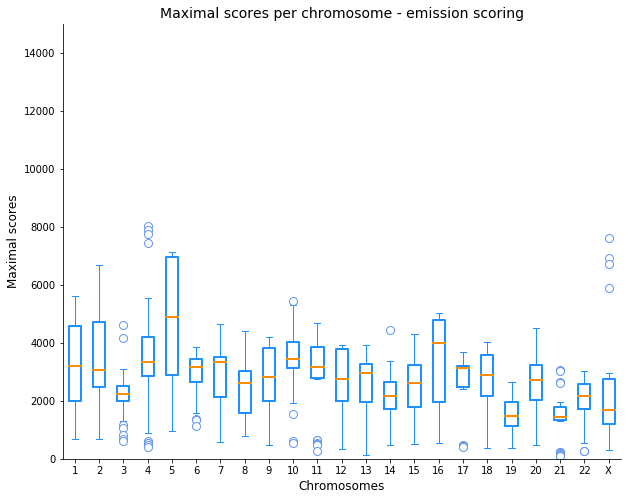

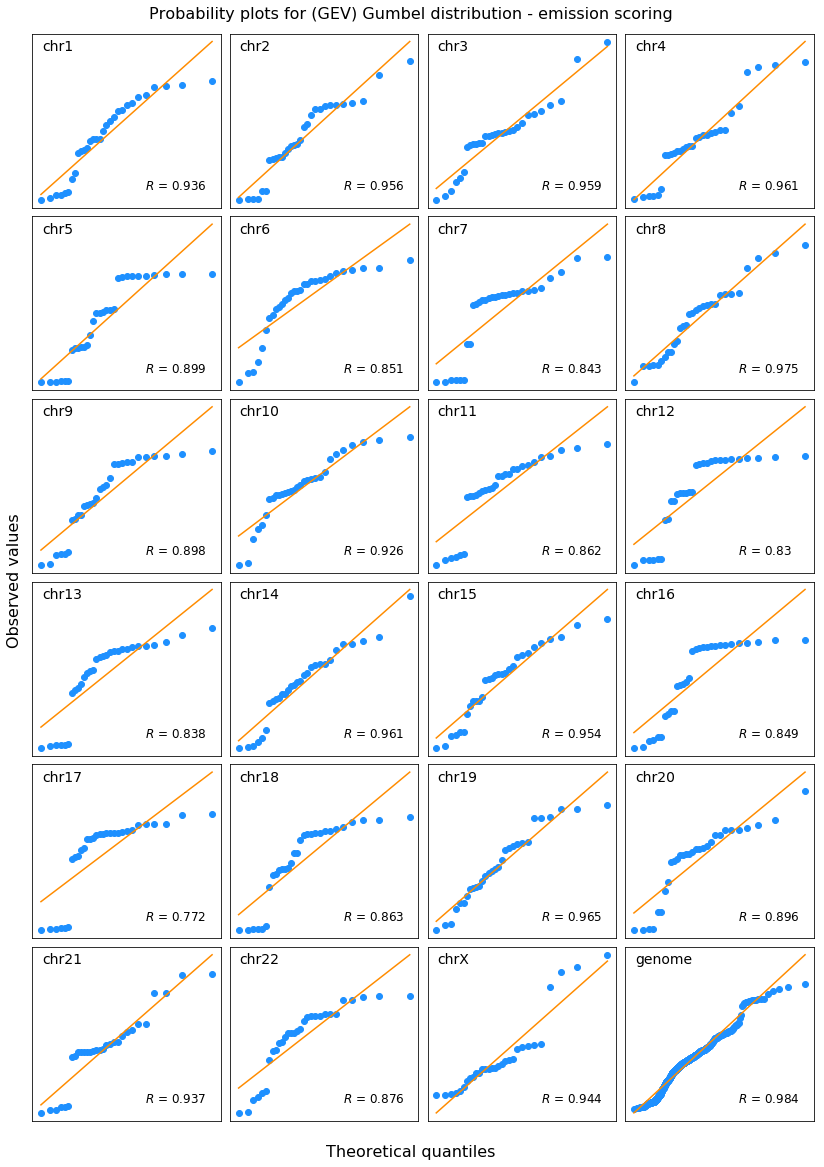

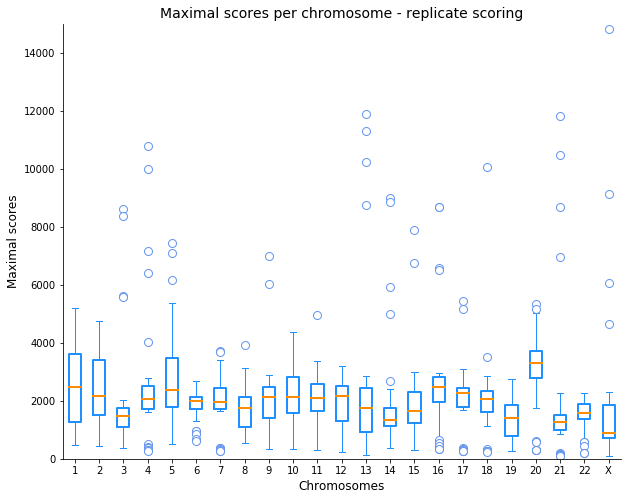

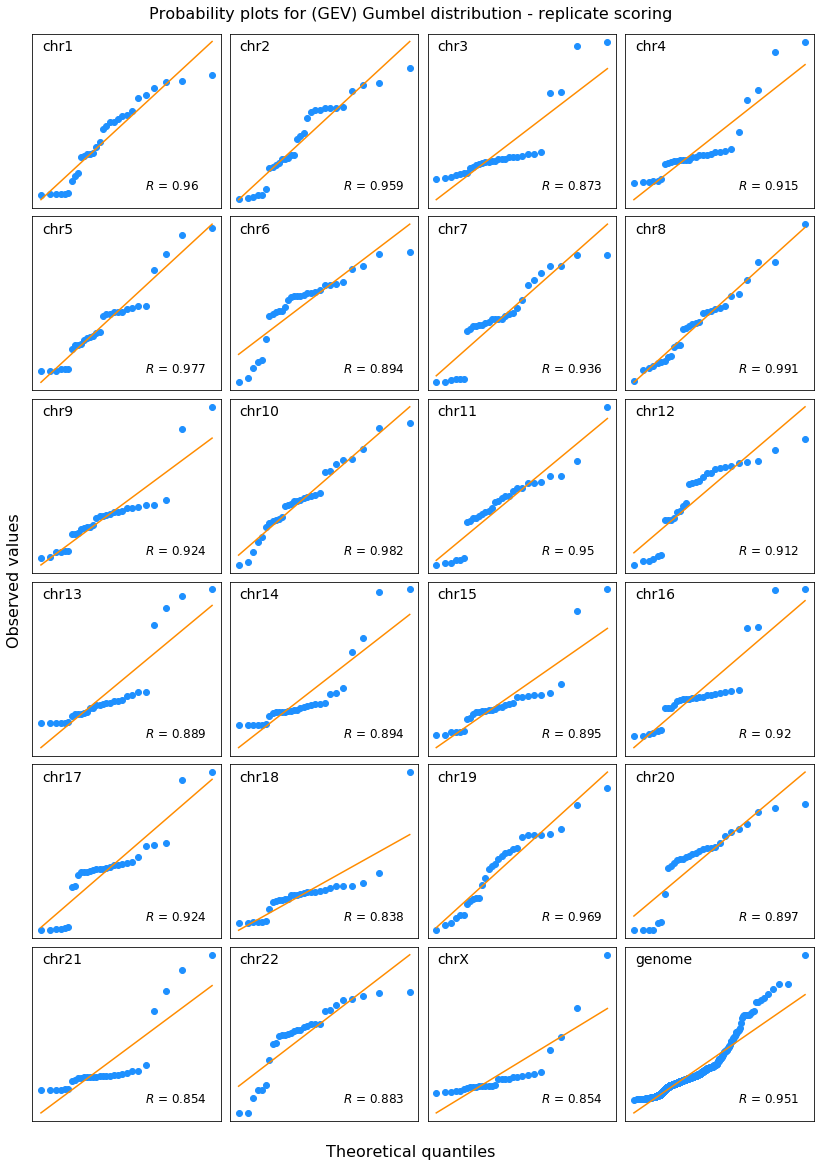

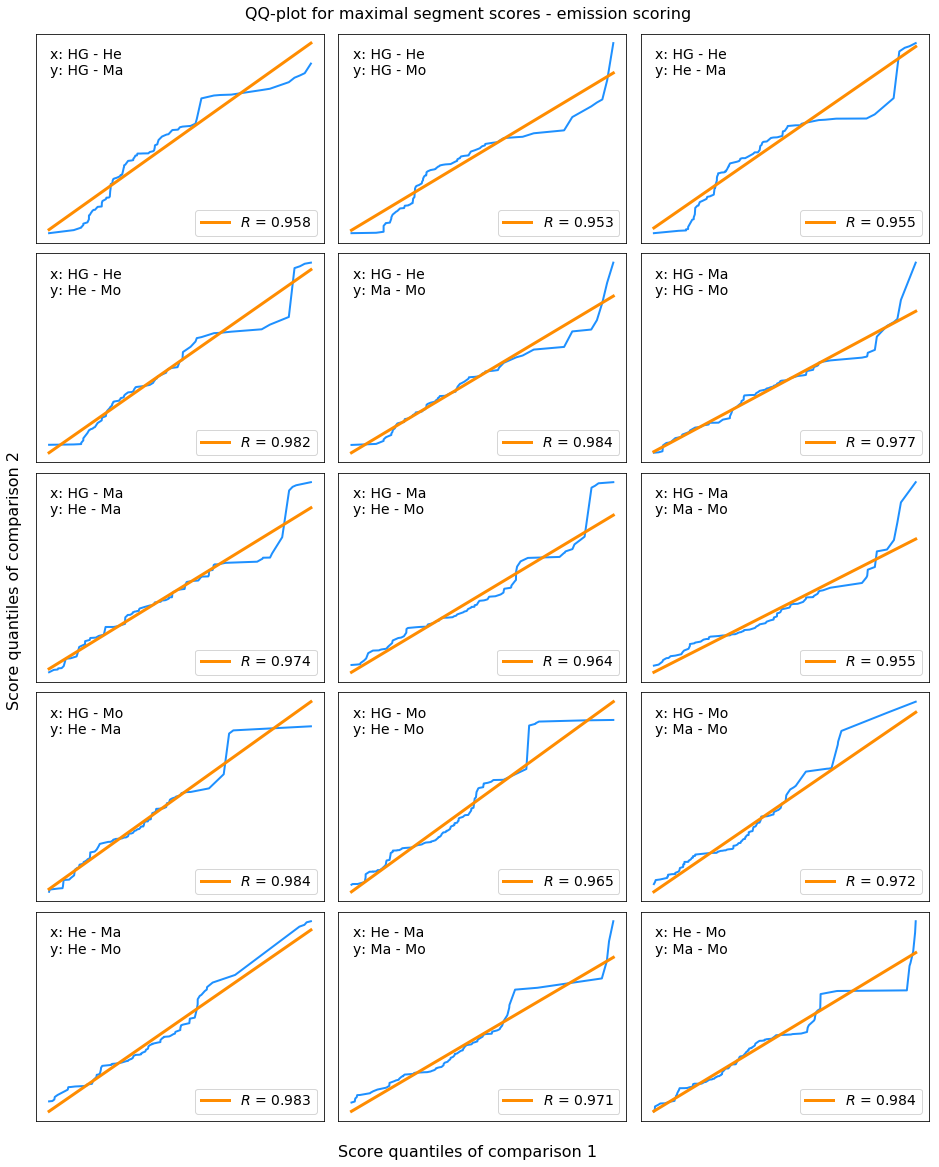

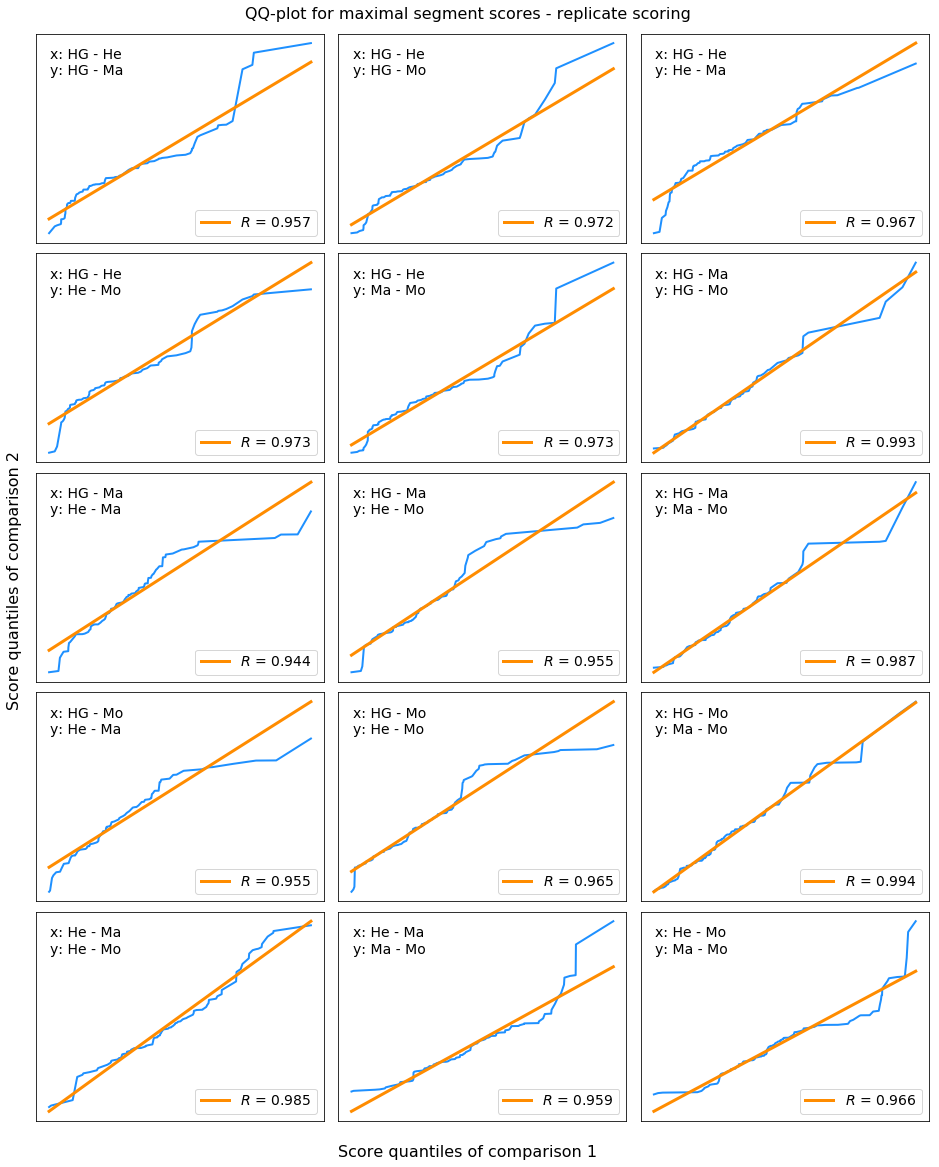

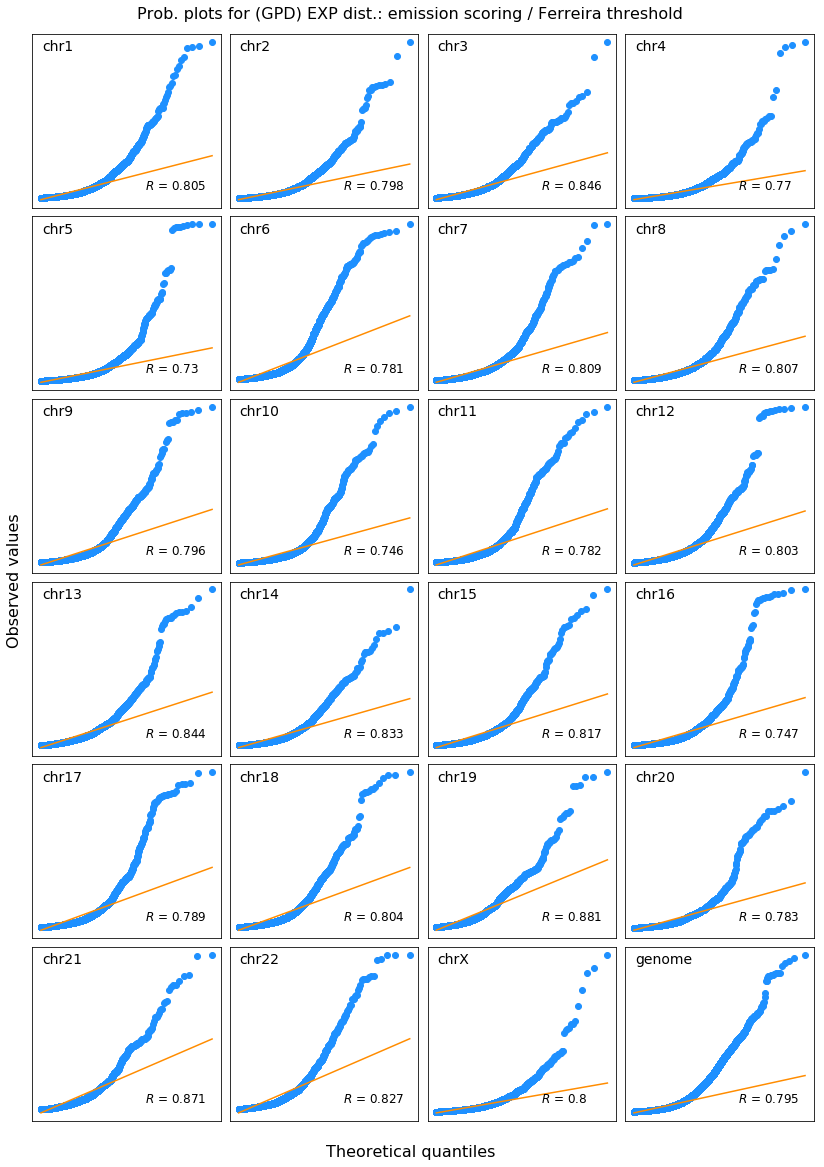

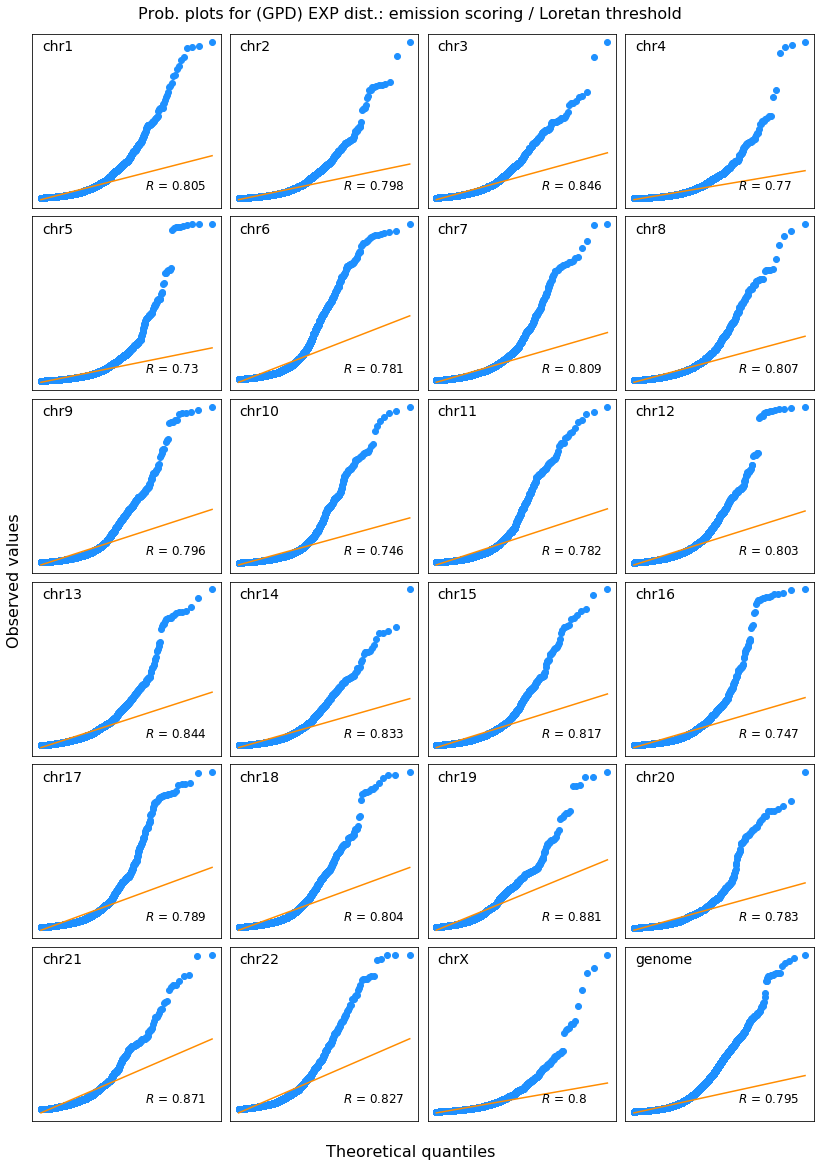

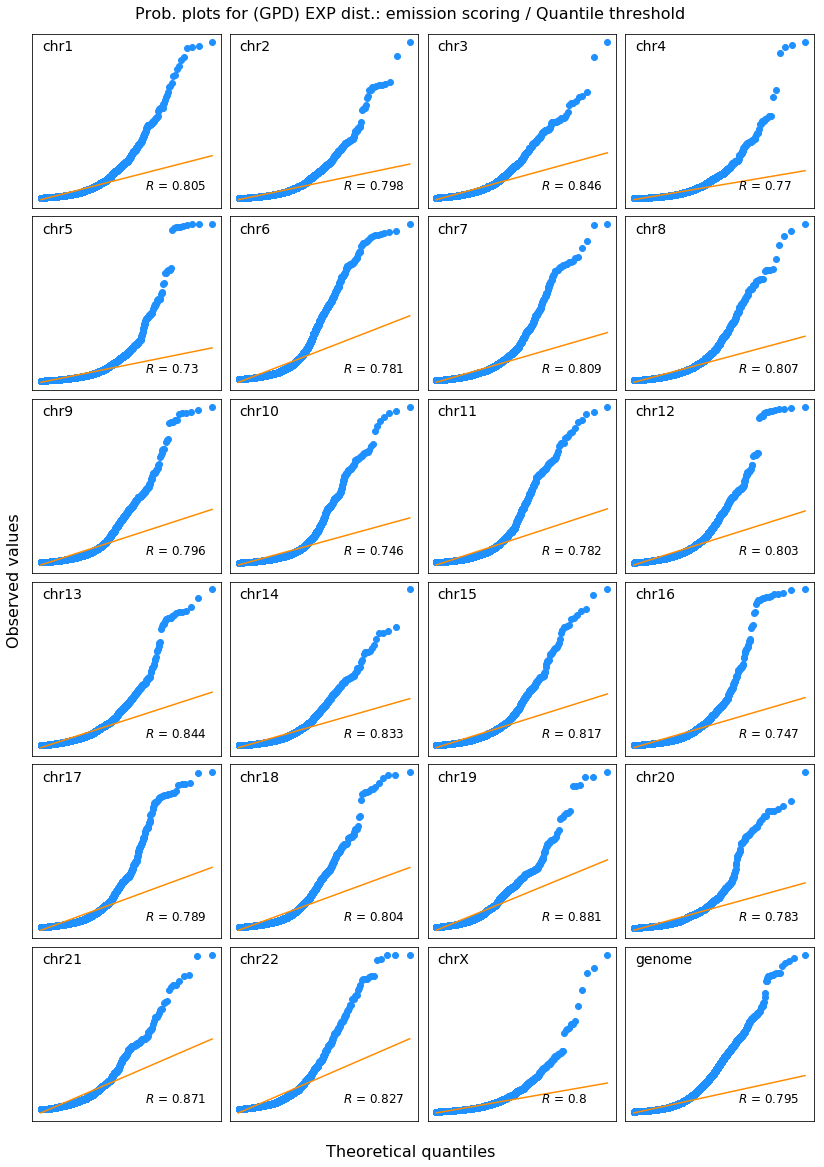

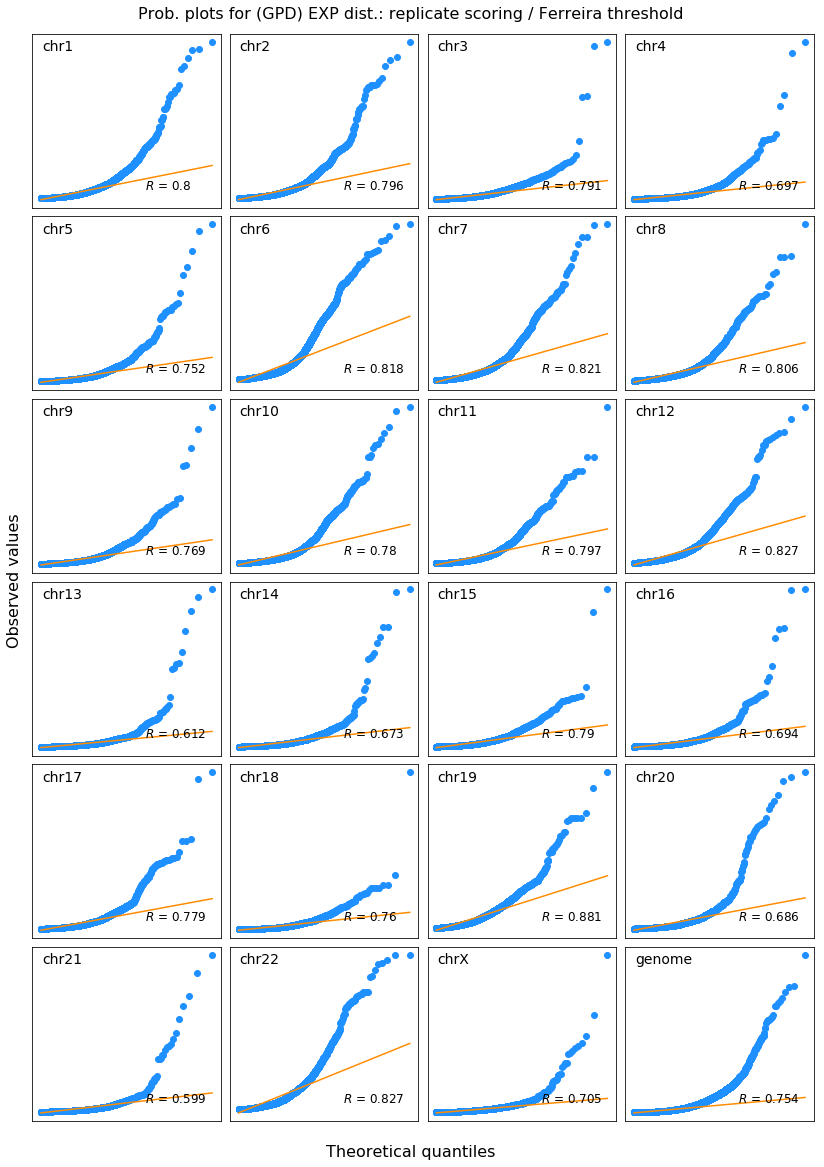

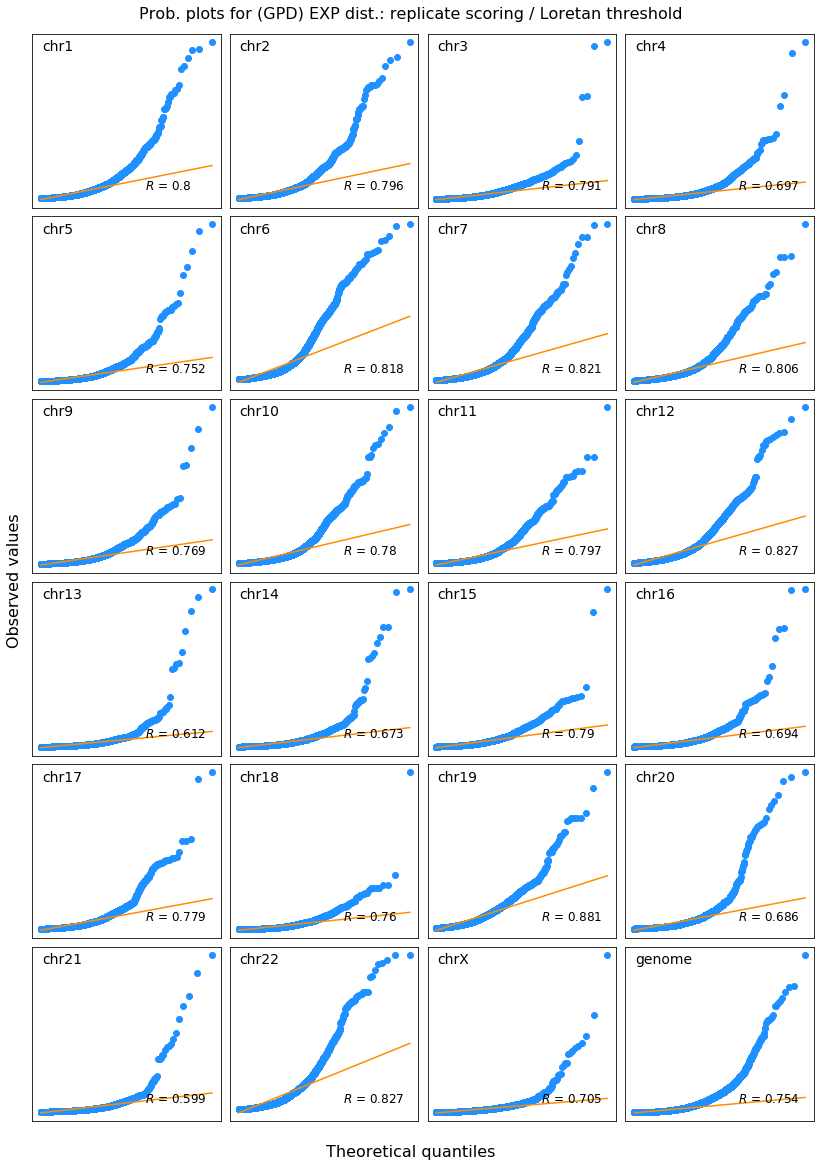

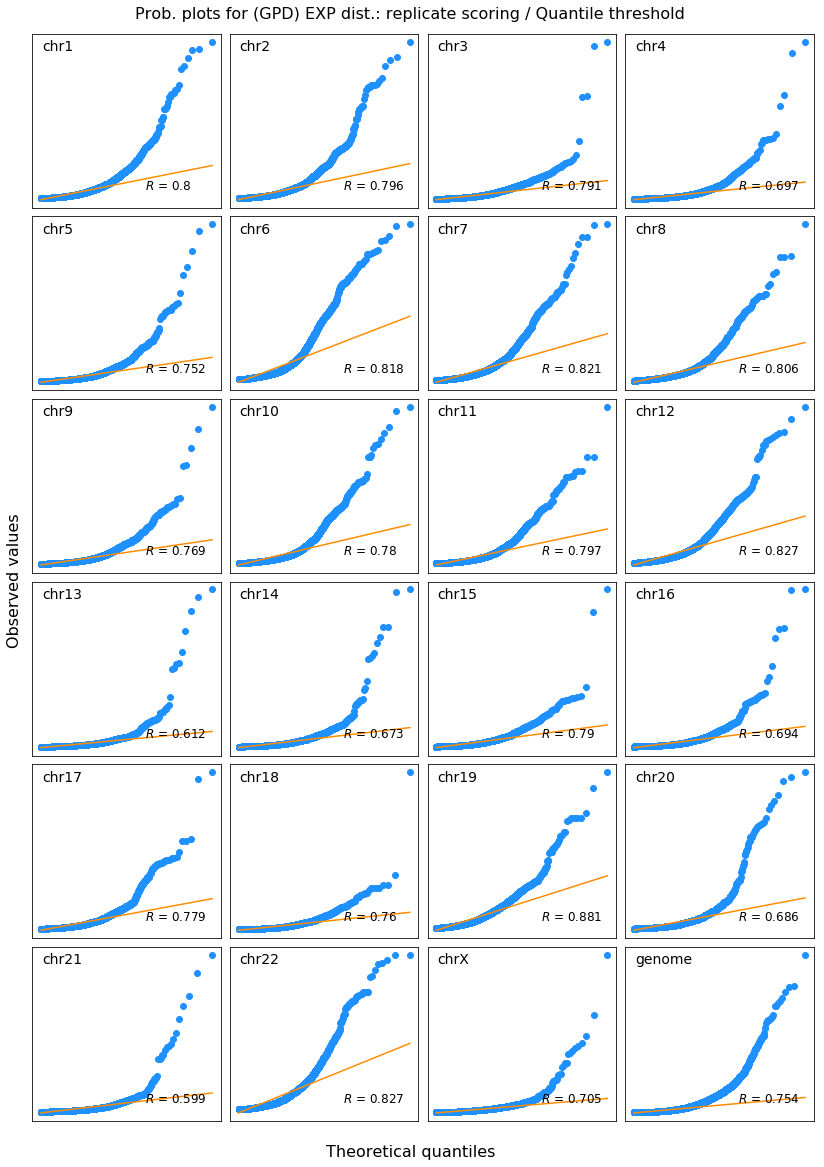

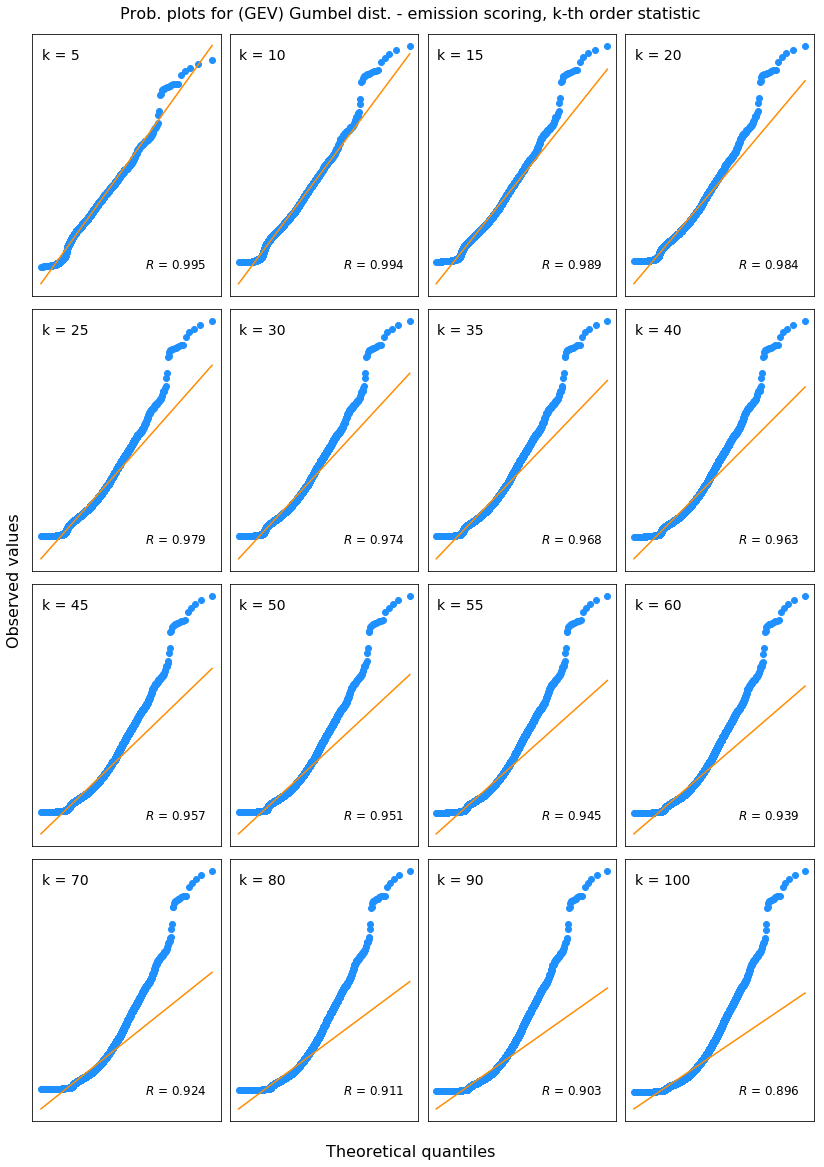

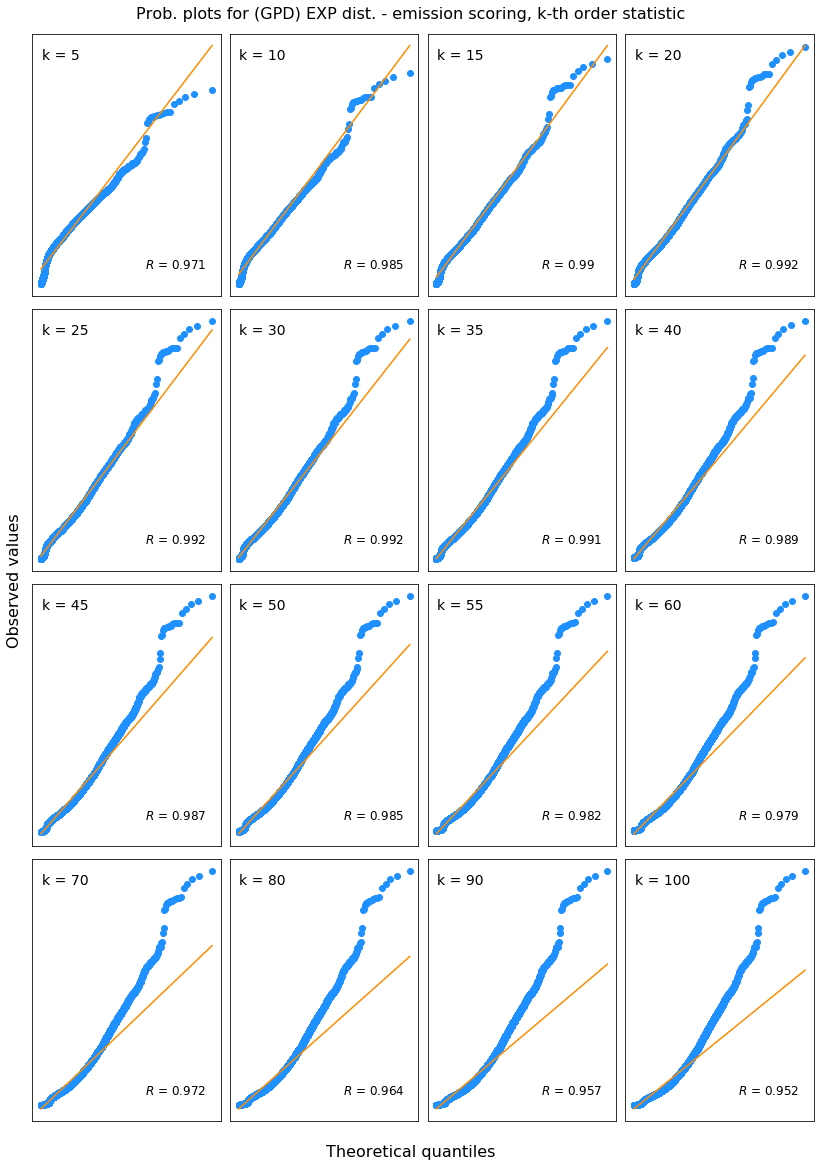

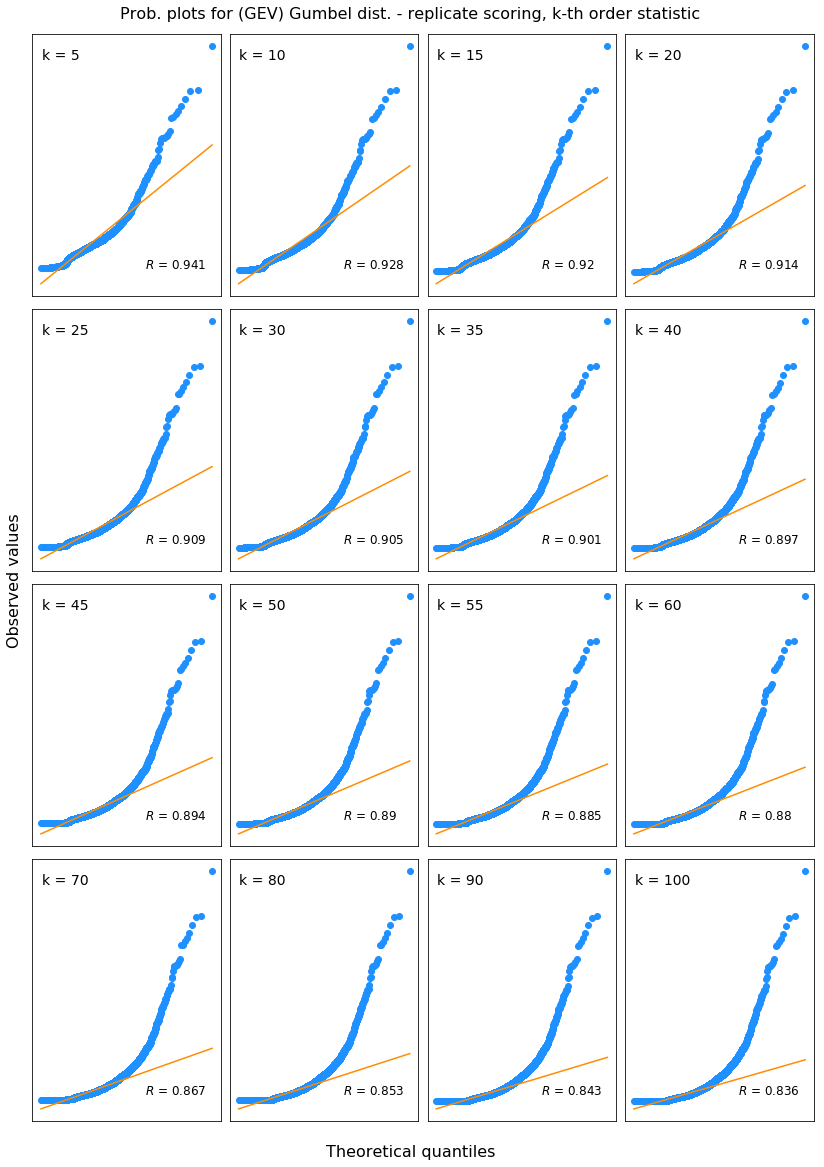

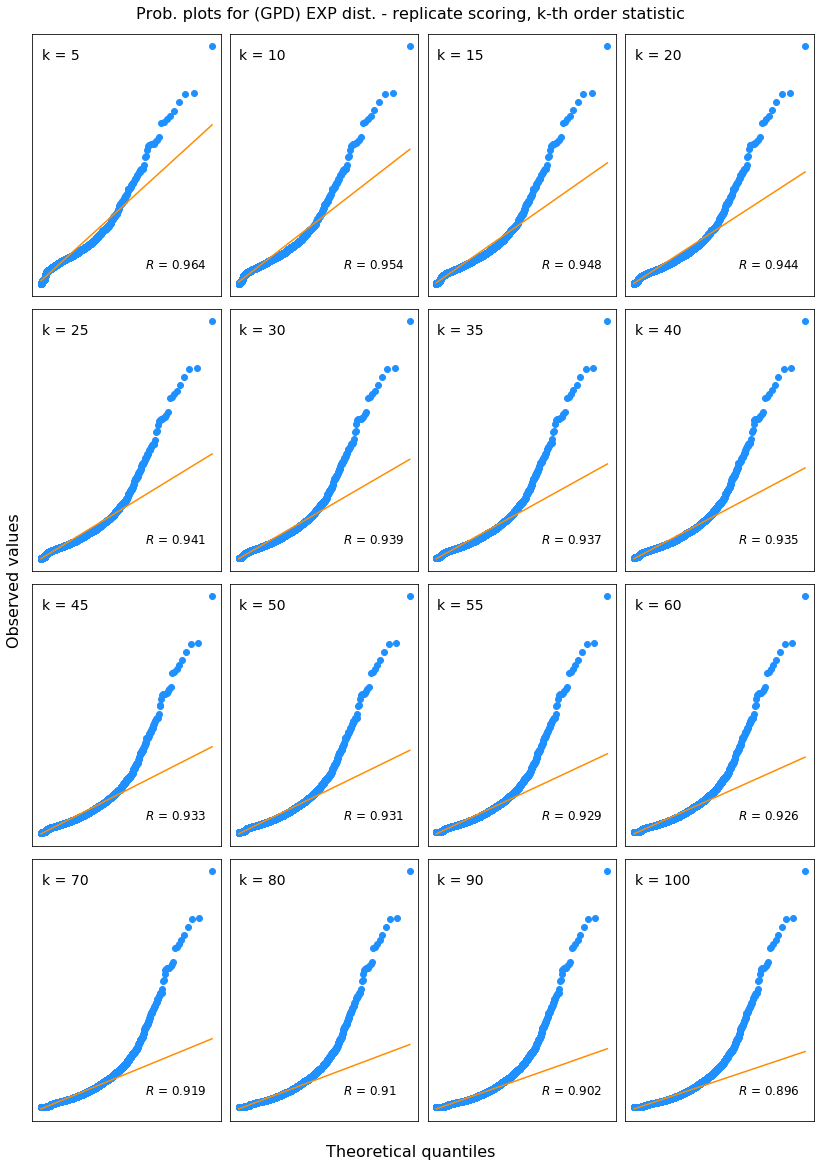

In [38]:
%matplotlib inline

def collect_block_maxima(fpaths, scoring, cache_file):
    """
    """
    if not os.path.isfile(cache_file):
        block_max = col.defaultdict(list)
        for fp in fpaths:
            with pd.HDFStore(fp, 'r') as hdf:
                load_keys = [k for k in hdf.keys() if k.startswith('/sstrun/{}'.format(scoring))]
                for k in load_keys:
                    if k.endswith('/thresholds'):
                        continue
                    data = hdf[k]
                    data = data.loc[data['is_hsp'] == 1, :].copy()
                    chrom = os.path.split(k)[1]
                    data['comparison'] = data['sample1'] + '-VS-' + data['sample2']
                    for comp in data['comparison'].unique():
                        sub = data.loc[data['comparison'] == comp, 'norm_nat_score']
                        block_max[chrom].append(float(sub.max()))
        ts = ti.ctime()
        with open(cache_file, 'w') as cache:
            js.dump({'timestamp': ts, 'data': block_max},
                     cache, sort_keys=True, indent=1)
    else:
        with open(cache_file, 'r') as cache:
            cached = js.load(cache)
            block_max = cached['data']
    return block_max

def collect_blockmax_comp(fpaths, scorings, cache_file):
    """
    """
    if not os.path.isfile(cache_file):
        block_max = dict()
        for s in scorings:
            block_max[s] = col.defaultdict(list)
        for fp in fpaths:
            with pd.HDFStore(fp, 'r') as hdf:
                for k in hdf.keys():
                    if k.endswith('/thresholds'):
                        continue
                    data = hdf[k]
                    data = data.loc[data['is_hsp'] == 1, :].copy()
                    _, _, scoring, chrom = k.split('/')
                    fname = os.path.basename(fp).split('.')[0]
                    parts = fname.split('_')
                    s1 = parts[2]
                    s2 = parts[5]
                    plot_comp = s1 + '_vs_' + s2
                    data['comparison'] = data['sample1'] + '_VS_' + data['sample2']
                    for comp in data['comparison'].unique():
                        sub = data.loc[data['comparison'] == comp, 'norm_nat_score']
                        block_max[scoring][plot_comp].append(float(sub.max()))
        ts = ti.ctime()
        with open(cache_file, 'w') as cache:
            js.dump({'timestamp': ts, 'data': block_max},
                     cache, sort_keys=True, indent=1) 
    else:
        with open(cache_file, 'r') as cache:
            cached = js.load(cache)
            block_max = cached['data']
    return block_max

def read_thresholds(fpath, score):
    """
    """
    thresholds = dict()
    with pd.HDFStore(fpath, 'r') as hdf:
        t_data = hdf['/sstrun/{}/thresholds'.format(score)]
        for c in t_data.columns:
            if c.endswith('_lo'):
                thresholds[c.split('_')[0]] = {'value': col.defaultdict(float),
                                               'percent': col.defaultdict(float)}
        for row in t_data.itertuples():
            thresholds['ferreira']['value'][row.index] = row.ferreira_lo
            thresholds['ferreira']['percent'][row.index] = row.ferreira_pct
            thresholds['loretan']['value'][row.index] = row.loretan_lo
            thresholds['loretan']['percent'][row.index] = row.loretan_pct
            thresholds['quantile']['value'][row.index] = row.quantile_lo
            thresholds['quantile']['percent'][row.index] = row.quantile_pct
    return thresholds

def collect_excess_scores(fpaths, score, cache_file):
    """
    """
    if not os.path.isfile(cache_file):
        excess_scores = {'ferreira': col.defaultdict(list),
                         'loretan': col.defaultdict(list),
                         'quantile': col.defaultdict(list)}
        for fp in fpaths:
            thresholds = read_thresholds(fp, score)
            with pd.HDFStore(fp, 'r') as hdf:
                load_keys = [k for k in hdf.keys() if k.startswith('/sstrun/{}'.format(score))]
                for k in load_keys:
                    if k.endswith('/thresholds'):
                        continue
                    data = hdf[k]
                    data = data.loc[data['is_hsp'] == 1, :].copy()
                    chrom = os.path.split(k)[1]
                    data['comparison'] = data['sample1'] + '-VS-' + data['sample2']
                    for comp in data['comparison'].unique():
                        sub = data.loc[data['comparison'] == comp, 'norm_nat_score']
                        for rule in ['ferreira', 'loretan', 'quantile']:
                            lower_bound = thresholds[rule]['value'][chrom]
                            excess = sub.loc[sub > lower_bound].copy()
                            excess -= lower_bound
                            excess_scores[rule][chrom].extend(list(map(float, excess)))
        ts = ti.ctime()
        with open(cache_file, 'w') as cache:
            js.dump({'timestamp': ts, 'data': excess_scores},
                     cache, sort_keys=True, indent=1)
    else:
        with open(cache_file, 'r') as cache:
            cached = js.load(cache)
            excess_scores = cached['data']
    return excess_scores

def collect_order_scores(fpaths, score, cache_file):
    """
    """
    if not os.path.isfile(cache_file):
        ranked_scores = []
        for fp in fpaths:
            with pd.HDFStore(fp, 'r') as hdf:
                load_keys = [k for k in hdf.keys() if k.startswith('/sstrun/{}'.format(score))]
                for k in load_keys:
                    if k.endswith('/thresholds'):
                        continue
                    data = hdf[k]
                    data = data.loc[data['is_hsp'] == 1, :].copy()
                    data['comparison'] = data['sample1'] + '-VS-' + data['sample2']
                    for comp in data['comparison'].unique():
                        sub = data.loc[data['comparison'] == comp, ['norm_nat_score']]
                        sub['rank'] = sub['norm_nat_score'].rank(method='dense', ascending=False)
                        ranked_scores.append(sub)
        ranked_scores = pd.concat(ranked_scores, axis=0, ignore_index=False)
        with pd.HDFStore(cache_file, 'w') as hdf:
            hdf.put('data', ranked_scores, format='fixed')
            hdf.flush()
    else:
        with pd.HDFStore(cache_file, 'r') as hdf:
            ranked_scores = hdf['data']
    return ranked_scores


def sort_label_chroms(chroms):
    """
    """
    chrom_sort = []
    for c in chroms:
        try:
            chrom_num = int(c.strip('chr'))
            chrom_sort.append((chrom_num, c.strip('chr'), c))
        except ValueError:
            chrom_num = 23
            chrom_sort.append((chrom_num, 'X', c))
    return sorted(chrom_sort)
    

def plot_block_maxima(bmax, scoring):
    """
    """
    chrom_sort = sort_label_chroms(list(bmax.keys()))
    plot_data = [bmax[t[2]] for t in chrom_sort]
    x_labels = [t[1] for t in chrom_sort]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    medianprops = {'color': 'darkorange', 'linewidth': 2}
    boxprops = {'color': 'dodgerblue', 'linewidth': 2}
    whiskerprops = {'color': 'dodgerblue'}
    capprops = {'color': 'dodgerblue'}
    flierprops = {'color': 'skyblue', 'marker': 'o',
                  'markerfacecolor': 'white', 'markersize': 8,
                  'markeredgecolor': 'cornflowerblue'}
    
    ax.set_ylim(0, 15000)
    
    ax.boxplot(plot_data, notch=False, labels=x_labels,
               boxprops=boxprops, medianprops=medianprops,
               whiskerprops=whiskerprops, capprops=capprops,
               flierprops=flierprops)
    
    ax.set_title('Maximal scores per chromosome - {} scoring'.format(scoring),
                 fontsize=14)
    
    ax.set_xlabel('Chromosomes', fontsize=12)
    ax.set_ylabel('Maximal scores', fontsize=12)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, []
    

def plot_qq_comp(plot_data, figtitle):
    """
    """
    total_subplots = len(plot_data.keys())
    total_subplots = int(scisp.comb(total_subplots, 2, repetition=False))
    num_cols = 3
    num_rows = total_subplots // num_cols
    fig, axes = plt.subplots(num_rows, num_cols,
                             sharex=False, sharey=False,
                             figsize=(16, 20))
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    ex_title = fig.text(0.5, 0.89, figtitle, ha='center', fontsize=16)
    ex_xlabel = fig.text(0.5, 0.1, 'Score quantiles of comparison 1',
                         ha='center', fontsize=16)
    ex_ylabel = fig.text(0.1, 0.5, 'Score quantiles of comparison 2',
                         va='center', rotation='vertical', fontsize=16)
    
    plot_order = sorted(plot_data.keys())
    r, c = 0, 0
    done = set()
    for x_comp in plot_order:
        for y_comp in plot_order:
            if x_comp == y_comp:
                continue
            if (x_comp, y_comp) in done or (y_comp, x_comp) in done:
                continue
            label_vals = x_comp.split('_') + y_comp.split('_')
            label_vals = tuple([label_vals[i] for i in [0,2,3,5]])
            label = 'x: {} - {}\ny: {} - {}'.format(*label_vals)
            ax = axes[r, c]
            c += 1
            if c == 3:
                c = 0
                r += 1
            x_vals = sorted(plot_data[x_comp])
            y_vals = sorted(plot_data[y_comp])
            if len(x_vals) < len(y_vals):
                est_quant = np.linspace(0, 1, num=len(x_vals), endpoint=True, dtype=np.float16)
                y_vals = mstats.mquantiles(y_vals, prob=est_quant, alphap=0, betap=1)
            elif len(x_vals) > len(y_vals):
                est_quant = np.linspace(0, 1, num=len(y_vals), endpoint=True, dtype=np.float16)
                x_vals = mstats.mquantiles(x_vals, prob=est_quant, alphap=0, betap=1)                
            else:
                pass
            ax.set(adjustable='box')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.plot(x_vals, y_vals, c='dodgerblue', lw=2)
            # manually add best fit reg line
            slope, inter, rvalue, pv, graderr = stats.linregress(x_vals, y_vals)
            reg_yvals = np.array(x_vals) * slope + inter
            ax.plot(x_vals, reg_yvals, c='darkorange', lw=3, label='$R$ = ' + str(np.round(rvalue, 3)) )
            ax.legend(loc='lower right', fontsize=14)
            # add label to plot
            ax.text(0.05, 0.8, label, fontsize=14, transform=ax.transAxes)
            done.add((x_comp, y_comp))
            done.add((y_comp, x_comp))
    return fig, []
   
def plot_probplot(data, figtitle, theo_dist, is_chrom=True):
    """
    """
    dist = {'gumbel_r': stats.gumbel_r.fit,
            'expon': stats.expon.fit,
            'weibull_max': stats.weibull_max.fit,
            'genextreme': stats.genextreme.fit,
            'genpareto': stats.genpareto.fit}
    total_subplots = len(data.keys()) + 1
    num_cols = 4
    num_rows = total_subplots // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols,
                             sharex=False, sharey=False,
                             figsize=(14, 20))
    fig_title = figtitle
    fig_xlabel = 'Theoretical quantiles'
    fig_ylabel = 'Observed values'
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    ex_title = fig.text(0.5, 0.89, fig_title, ha='center', fontsize=16)
    ex_xlabel = fig.text(0.5, 0.1, fig_xlabel, ha='center', fontsize=16)
    ex_ylabel = fig.text(0.1, 0.5, fig_ylabel, va='center', rotation='vertical', fontsize=16)
    
    if is_chrom:
        plot_infos = sort_label_chroms(list(data.keys()))
        plot_infos.append((24, 'gen.', 'genome'))
    else:
        plot_infos = sorted([(k, k, k) for k in data.keys()])
    
    r, c = 0, 0
    gw_data = []
    for num, short, name in plot_infos:
        ax = axes[r, c]
        c += 1
        if c == 4:
            c = 0
            r += 1
        try:
            chrom_data = data[name]
            gw_data += chrom_data
        except KeyError:
            chrom_data = gw_data
        try:
            est_param = dist[theo_dist](chrom_data)
        except FloatingPointError:
            print('Skipping {}'.format(name))
            continue
        (osm, osr), (slope, inter, cod) = stats.probplot(chrom_data, est_param,
                                                         dist=theo_dist, fit=True, plot=ax)
        ax.set_xticks([])
        ax.set_yticks([])
        # markers
        ax.get_lines()[0].set_color('dodgerblue')
        # trendline
        ax.get_lines()[1].set_color('darkorange')
        ax.set_title('')
        
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        if is_chrom:
            ax.text(0.05, 0.9, name, fontsize=14, transform=ax.transAxes)
        else:
            ax.text(0.05, 0.9, 'k = {}'.format(name), fontsize=14, transform=ax.transAxes)
        
        cod = str(np.round(cod, 3))
        ax.text(0.6, 0.1, '$R$ = ' + cod, fontsize=12, transform=ax.transAxes)
           
    return fig, [ex_title, ex_xlabel, ex_ylabel]

def plot_joint_fit(hsps, rands):
    """
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    
    x_values = np.linspace(rands.min(), hsps.max(), 10000)
    
    hsps_loc, hsps_scale = stats.gumbel_r.fit(hsps)
    hsps_exp = stats.gumbel_r.pdf(x_values,
                                  loc=hsps_loc,
                                  scale=hsps_scale)
    
    rands_loc, rands_scale = stats.gumbel_l.fit(rands)
    rands_exp = stats.gumbel_l.pdf(x_values,
                                   loc=rands_loc,
                                   scale=rands_scale)
    
    _ = ax.hist(np.concatenate([hsps, rands]), normed=True,
                bins=100, alpha=0.4, color='blue',
                histtype='stepfilled', label='Observed / sampled')
    
    _ = ax.plot(x_values, rands_exp, lw=2, color='black', label='Fit (Gumbel [L])')

    _ = ax.plot(x_values, hsps_exp, lw=2, color='darkorange', label='Fit (Gumbel [R])')
    
    _ = ax.legend(loc='upper center', fontsize=12)
    _ = ax.set_title('Observed and random scores', fontsize=16)
    
    return fig, []

    
def plot_dist_fit(obs_data, title, gumbel_type):
    """
    """
    x_values = np.linspace(obs_data.min(), obs_data.max(), 100)
    
    if gumbel_type == 'right':
        gumbel_label = 'Fit (Gumbel [R])'
        gumbel_loc, gumbel_scale = stats.gumbel_r.fit(obs_data)
        gumbel_exp = stats.gumbel_r.pdf(x_values,
                                        loc=gumbel_loc,
                                        scale=gumbel_scale)
    else:
        gumbel_label = 'Fit (Gumbel [L])'
        gumbel_loc, gumbel_scale = stats.gumbel_l.fit(obs_data)
        gumbel_exp = stats.gumbel_l.pdf(x_values,
                                        loc=gumbel_loc,
                                        scale=gumbel_scale)
    
    norm_loc, norm_scale = stats.norm.fit(obs_data)
    norm_exp = stats.norm.pdf(x_values,
                              loc=norm_loc,
                              scale=norm_scale)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    _ = ax.hist(obs_data, normed=True, bins=100, alpha=0.5,
                histtype='stepfilled', color='blue', label='Observed')

    _ = ax.plot(x_values, norm_exp, lw=4, color='black', label='Fit (Norm)')

    _ = ax.plot(x_values, gumbel_exp, lw=5, color='darkorange',
                label=gumbel_label, alpha=0.8)

    _ = ax.legend(loc='upper center', fontsize=12)
    _ = ax.set_title(title, fontsize=16)
    
    return fig, []


def plot_bin_scores(hsps, rands):
    """
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    
    joint_values = np.concatenate([hsps, rands])
    
    x_values = np.linspace(joint_values.min(), joint_values.max(), 100)
    
    hsp_loc, hsp_scale = stats.norm.fit(hsps)
    hsp_exp = stats.norm.pdf(x_values,
                             loc=hsp_loc,
                             scale=hsp_scale)
    
    rand_loc, rand_scale = stats.norm.fit(rands)
    rand_exp = stats.norm.pdf(x_values,
                              loc=rand_loc,
                              scale=rand_scale)
    
    
    ax.hist(joint_values, normed=True, bins=100, alpha=0.5,
            histtype='stepfilled', color='blue', label='Observed / random')
    
    ax.plot(x_values, rand_exp, color='black',
            alpha=0.8, lw=4)
    
    ax.plot(x_values, hsp_exp, color='darkorange',
            alpha=0.8, lw=4)

    return fig, []


def plot_param_dep(metadata, leg_locations, scoring):
    """
    """
    leg_loc1, leg_loc2 = leg_locations
    
    fig, ax1 = plt.subplots(figsize=(10, 10))
    
    metadata.drop('genome', axis=0, inplace=True)
    metadata.sort_values('norm_factor', ascending=True, inplace=True)
    x_ticklabels = [(row.norm_factor, row.Index) for row in metadata.itertuples()]
    
    x_ticks = []
    x_labels = []
    for idx, (num, chrom) in enumerate(x_ticklabels):
        if chrom in ['chr21', 'chrX', 'chr10', 'chr3', 'chr2']:
            x_labels.append('{}\n{}'.format(chrom, int(num // 1000)))
        else:
            x_labels.append('')
        x_ticks.append(num)   
    
    ax1_rho = np.round(stats.spearmanr(metadata['norm_factor'], metadata['ka_lambda'])[0], 2)
    
    ax1.plot(metadata['norm_factor'].values,
             metadata['ka_lambda'].values,
             'bo', label=r'$\lambda\/(\rho\/\approxeq' + str(ax1_rho) + ')$')
    ax1.set_ylabel('Karlin-Altschul parameter: $\lambda$', fontsize=14)
    ax1.set_xlabel('Average number of variable bins (x1000)', fontsize=14)
    
    ax1.legend(loc=leg_loc1, fontsize=14)
    
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_labels, fontdict={'fontsize': 12})
    
    ax2 = ax1.twinx()
    
    ax2_rho = np.round(stats.spearmanr(metadata['norm_factor'], metadata['ka_k'])[0], 2)
    
    ax2.plot(metadata['norm_factor'].values,
            metadata['ka_k'].values,
            'ro', label=r'$K\/(\rho\/\approxeq' + str(ax2_rho) + ')$')
    ax2.set_ylabel('Karlin-Altschul parameter: $K$', fontsize=14)
    
    ax2.legend(loc=leg_loc2, fontsize=14)
    
    ax2.set_title('# variable bins vs. Karlin-Altschul param. (Spearman\'s $\\rho$ ; ' + scoring + ' scoring)',
                  fontsize=14)
    if show_figures:
        plt.show()
    return fig, []
    

if ka_dependence:
    with pd.HDFStore(dset_file, 'r') as hdf:
        for score, leg_loc in zip(scorings, [[(0.05, 0.925), (0.05, 0.85)],
                                             [(0.7, 0.925), (0.7, 0.85)]]):
            score_md = hdf['/scoring/{}/parameters'.format(score)]
            fig, exart = plot_param_dep(score_md, leg_loc, score)
            if save_figures:
                outpath = os.path.join(fig_supp, 'fig_X_supp_param-dep_{}.svg'.format(score))
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                outpath = outpath.replace('.svg', '.png')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)


if run_diagnostics:
    if run_blockmax:
        # step 1: modeling based on block maxima
        for score in scorings:
            score_cache = os.path.join(cache_dir, 'blockmax_{}.json'.format(score))
            bm = collect_block_maxima(run_files, score, score_cache)
            fig, exart = plot_block_maxima(bm, score)
            if save_figures:
                outpath = os.path.join(fig_supp, 'fig_X_supp_blockmax_{}.svg'.format(score))
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                outpath = outpath.replace('.svg', '.png')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
            title = 'Probability plots for (GEV) Gumbel distribution - {} scoring'.format(score)  
            fig, exart = plot_probplot(bm, title, 'gumbel_r')
            if save_figures:
                outpath = os.path.join(fig_supp, 'fig_X_supp_bmax-gumbel_{}.svg'.format(score))
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                outpath = outpath.replace('.svg', '.png')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
        # check that individual comparisons
        # give rise to roughly the same distribution
        score_cache = os.path.join(cache_dir, 'blockmax_comp.json')
        bm = collect_blockmax_comp(run_files, scorings, score_cache)
        for score in scorings:
            title = 'QQ-plot for maximal segment scores - {} scoring'.format(score)
            fig, exart = plot_qq_comp(bm[score], title)
            if save_figures:
                outpath = os.path.join(fig_supp, 'fig_X_supp_qqplot_{}.svg'.format(score))
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                outpath = outpath.replace('.svg', '.png')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
        

    if run_excess:
        # step 2: modeling based on threshold excess
        # empirical rules of thumb seem not to be
        # appropriate for this data
        # No GPD/EXP fit for threshold excess
        for score in scorings:
            score_cache = os.path.join(cache_dir, 'excess_{}.json'.format(score))
            exc = collect_excess_scores(run_files, score, score_cache)
            for trule in ['ferreira', 'loretan', 'quantile']:
                exscores = exc[trule]
                title = 'Prob. plots for (GPD) EXP dist.: {} scoring / {} threshold'.format(score, trule.capitalize())
                fig, exart = plot_probplot(exscores, title, 'expon')

    if run_korder:
        # step 3: modeling based on k-order statistics
        for score in scorings:
            score_cache = os.path.join(cache_dir, 'orderstat_{}.h5'.format(score))
            ordstat = collect_order_scores(run_files, score, score_cache)
            plot_data = dict()
            for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]:
                k_data = ordstat.loc[ordstat['rank'] < k + 1, 'norm_nat_score'].copy()
                plot_data[k] = k_data.values.tolist()
            title = 'Prob. plots for (GEV) Gumbel dist. - {} scoring, k-th order statistic'.format(score)  
            fig, exart = plot_probplot(plot_data, title, 'gumbel_r', False)
            if save_figures:
                outpath = os.path.join(fig_supp, 'fig_X_supp_kord-gumbel_{}.svg'.format(score))
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                outpath = outpath.replace('.svg', '.png')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)

            title = 'Prob. plots for (GPD) EXP dist. - {} scoring, k-th order statistic'.format(score)  
            fig, exart = plot_probplot(plot_data, title, 'expon', False)
            if save_figures:
                outpath = os.path.join(fig_supp, 'fig_X_supp_kord-expon_{}.svg'.format(score))
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                outpath = outpath.replace('.svg', '.png')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
            
        
